In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import colorcet as cc
from matplotlib.colors import ListedColormap

import datetime
import glob

## download active fire data from the NASA archive:

In [ ]:
# download latest data from NASA's MODIS and VIIRS satellites:
#
modis_7day = pd.read_csv('https://firms.modaps.eosdis.nasa.gov/active_fire/c6/text/MODIS_C6_USA_contiguous_and_Hawaii_7d.csv')
viirs_7day = pd.read_csv('https://firms.modaps.eosdis.nasa.gov/active_fire/viirs/text/VNP14IMGTDL_NRT_USA_contiguous_and_Hawaii_7d.csv')

datestr = datetime.datetime.today().strftime("%Y-%m-%d")

# save to disk, for later use:
#
modis_7day.to_csv('archival-data/modis_7day_' + datestr + '.csv', encoding='utf-8', index=False)
viirs_7day.to_csv('archival-data/viirs_7day_' + datestr + '.csv', encoding='utf-8', index=False)

In [2]:
# open archival data, downloaded separately
#
viirs_archive = pd.read_csv('archival-data/fire_nrt_V1_22535.csv')
modis_archive = pd.read_csv('archival-data/fire_archive_M6_22534.csv')

In [3]:
def merge_datasets(glob_patt):
    files = glob.glob(glob_patt)
    first = files.pop()

    df = pd.read_csv(first)

    for f in files:
        df2 = pd.read_csv(f)
        temp = pd.concat([df, df2])
        df = temp.drop_duplicates().reset_index(drop=True)
    
    return df

thomas_fire_modis = merge_datasets('archival-data/modis_7day_*.csv')
thomas_fire_viirs = merge_datasets('archival-data/viirs_7day_*.csv')

## define some colors:

We will use the colorcet *fire* colormap to show the progression of the Thomas fire, from red to yellow.  And we'll use a dark red from the same colormap to show old fires from the archive.

In [4]:
thomas_dates = np.unique(np.append(thomas_fire_modis['acq_date'].values,
                                   thomas_fire_viirs['acq_date'].values))
thomas_dates.sort()

In [5]:
# use the colorcet "fire" colormap, but start 1/3 of the way through the colormap
# since the beginning is so dark
#
colors = cc.fire;
colors = colors[len(colors)/3:int(0.95*len(colors))]

# use a dark color from the same map for archival fires
#
archive_color = cc.fire[len(cc.fire)/3 - 16] # alternatively '#d500ff'

# match up indices
#
color_indices = np.round(np.linspace(0, len(colors)-1, len(thomas_dates))).astype(int)
colors = [ colors[i] for i in color_indices ]

# next, we need to make a separate colormap for each day of the fire.
# the color will stay the same, but the opacity increases with intensity of the fire.
#
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(1.0*int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4))

def hex_to_colormap(h, expt=0.5, fact=1.0):
    """Given a hex color of the form #667788, return a matplotlib colormap
    corresponding to that color.  The color stays the same, but the transparency
    increases from 0 to fact, with exponent expt."""
    r, g, b = hex_to_rgb(h)
    
    num = 256
    colors = [ [r, g, b, fact*(1.0*i/256)**expt] for i in range(num)]
    
    return ListedColormap(colors)

colormaps = map(hex_to_colormap, colors)
archive_colormap = hex_to_colormap(archive_color, expt=0.25, fact=0.5)

## make a map of the region and use it to get the bounding latitudes and longitudes for later maps

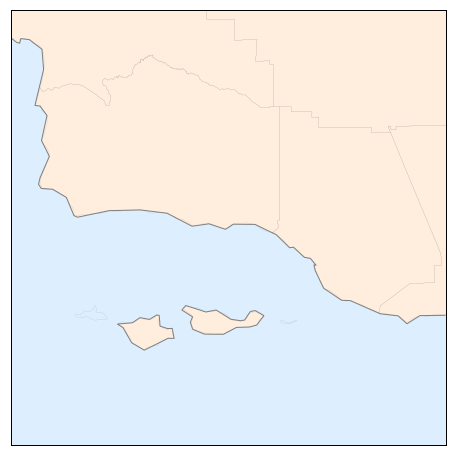

In [7]:
fig = plt.figure(figsize=(8,8))
m = Basemap(projection='lcc', resolution='i',
           width=2e5, height=2e5,
           lat_0=34.4, lon_0=-119.7)

m.drawmapboundary(fill_color='#DDEEFF');
m.fillcontinents(color='#FFEEDD');
m.drawcoastlines(color='gray', zorder=2);
m.drawcounties(color='gray', zorder=2);

In [8]:
lons = np.linspace(m.boundarylonmin, m.boundarylonmax, 200) # ~1 km resolution
lats = np.linspace(np.min(m.boundarylats), np.max(m.boundarylats), 200)

X, Y = np.meshgrid(lons, lats)

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy)

## make a 2D map of the fire data

Both MODIS and VIIRS provide data in the form of "active fire locations."  Each active fire location represents the center of a pixel that is flagged by the satellite as containing a fire within the pixel.

MODIS has 1 km pixels, while VIIRS has 375 m pixels.

I'll use a kernel density estimate to smooth these detections out into a map.  Note that I treat every detection equally, which could certainly be improved!  In particular, it would be good to
1. scale points by the temperature or intensity of the detection, and 
2. correct for bias (NASA has more satellites now than it used to, so older fires are less well-sampled than more recent ones).

In [9]:
from sklearn.neighbors import KernelDensity

In [10]:
def make_data(date, df, bw):
    def get_latlon(df):
        return (df[df['acq_date'] == date][['latitude', 'longitude']]).values
    
    if date != None:
        latlon = get_latlon(df)
    else:
        latlon = (df[['latitude', 'longitude']]).values
    
    kde = KernelDensity(bandwidth=bw, metric='haversine')
    kde.fit(np.radians(latlon))
    
    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    return Z

# MODIS has a resolution of 1 km, and VIIRS has a resolution of 375m.
# empirically, blurring these by an extra ~50% makes for a smoother plot
#
km = 1.0 / 6400
m_data = [ make_data(date, thomas_fire_modis, 1.0   * 1.5 * km) for date in thomas_dates ]
v_data = [ make_data(date, thomas_fire_viirs, 0.375 * 1.5 * km) for date in thomas_dates ]

In [11]:
# blur the archival data to 2km resolution
#
av_data = make_data(None, viirs_archive, 2.0 * km)
am_data = make_data(None, modis_archive, 2.0 * km)

In [12]:
data = [ m + v for m, v in zip(m_data, v_data) ]

adata = av_data + am_data

In [13]:
from math import log10
mx = log10(np.max(data))
levels = np.logspace(mx-3, mx, num=256)

mx = log10(np.max(adata))
alevels = np.logspace(mx-5, mx, num=256)

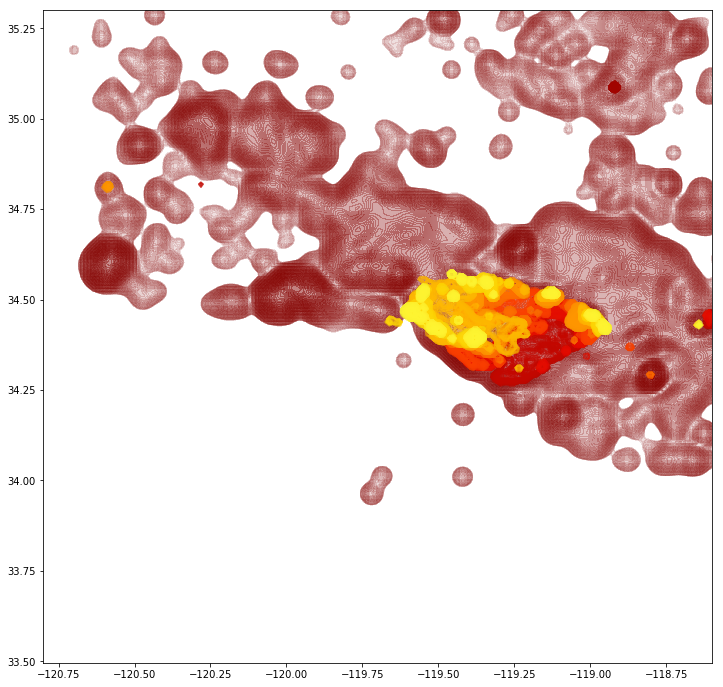

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

ax.contourf(X, Y, adata, levels=alevels, cmap=archive_colormap, zorder=2);

for i, Z in enumerate(v_data):
    ax.contourf(X, Y, Z, levels=levels[2:], cmap=colormaps[i], zorder=4);

## make the maps!

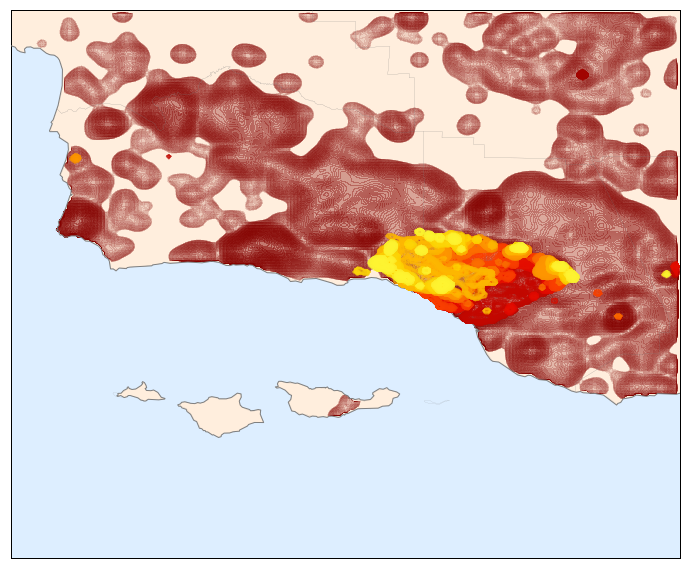

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

m = Basemap(projection='cyl', llcrnrlat=Y.min(),
            urcrnrlat=Y.max(), llcrnrlon=X.min(),
            urcrnrlon=X.max(), resolution='h', ax=ax)

def landq(pt):
    p = m(*(pt[::-1])) # reverse coordinates and use map projection
    return m.is_land(*p)

land_mask = np.asarray([ landq(pt) for pt in xy * 180 / np.pi ])
land_mask = land_mask.reshape(Z.shape)

m.drawmapboundary(fill_color='#DDEEFF');
m.fillcontinents(color='#FFEEDD');

con = adata
con[~land_mask] = -9999.0
ax.contourf(X, Y, con, levels=alevels, cmap=archive_colormap, zorder=2);

m.drawcoastlines(color='gray', zorder=3);
m.drawcounties(color='gray', zorder=3);

for i, Z in enumerate(v_data):
    con = Z
    con[~land_mask] = -9999.0
    ax.contourf(X, Y, con, levels=levels[2:], cmap=colormaps[i], zorder=4);

In [16]:
fig.savefig('thomas-fire-plain.png', dpi=150, bbox_inches='tight')

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-120.801735234,33.4959342375,-118.598264766,35.2992850043&bboxSR=4269&imageSR=4269&size=1500,1227&dpi=96&format=png32&f=image


/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


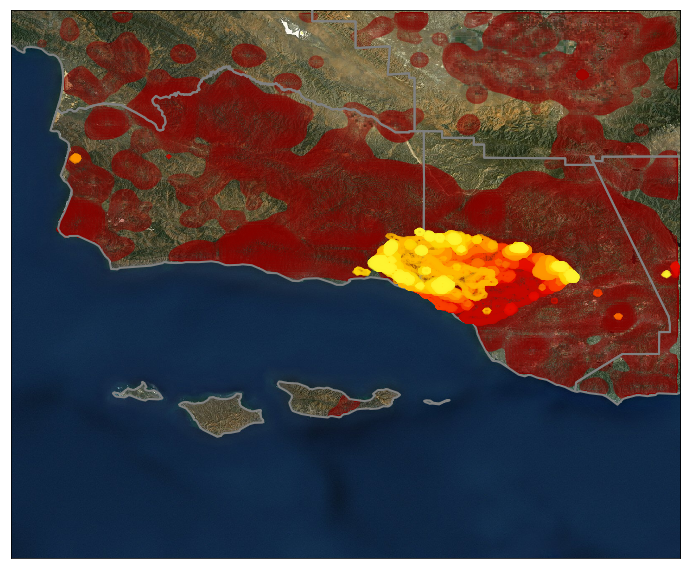

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

m = Basemap(#projection='cyl',
            llcrnrlat=Y.min(), urcrnrlat=Y.max(),
            llcrnrlon=X.min(), urcrnrlon=X.max(), epsg=4269, resolution='h')
#http://server.arcgisonline.com/arcgis/rest/services
#EPSG Number of America is 4269

def landq(pt):
    p = m(*(pt[::-1])) # reverse coordinates and use map projection
    return m.is_land(*p)

land_mask = np.asarray([ landq(pt) for pt in xy * 180 / np.pi ])
land_mask = land_mask.reshape(Z.shape)

# 'World_Physical_Map'
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1500, verbose=True, ax=ax);

#m.drawmapboundary(fill_color='#DDEEFF');
#m.fillcontinents(color='#FFEEDD');

con = adata
con[~land_mask] = -9999.0
ax.contourf(X, Y, con, levels=alevels, cmap=archive_colormap, zorder=2);

#m.drawcoastlines(color='gray', zorder=3, linewidth=2);
m.drawcounties(color='gray', zorder=3, linewidth=2);

for i, Z in enumerate(v_data):
    con = Z
    con[~land_mask] = -9999.0
    ax.contourf(X, Y, con, levels=levels[2:], cmap=colormaps[i], zorder=4);

In [18]:
fig.savefig('thomas-fire.png', dpi=200, bbox_inches='tight')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-120.801735234,33.4959342375,-118.598264766,35.2992850043&bboxSR=4269&imageSR=4269&size=1500,1227&dpi=96&format=png32&f=image


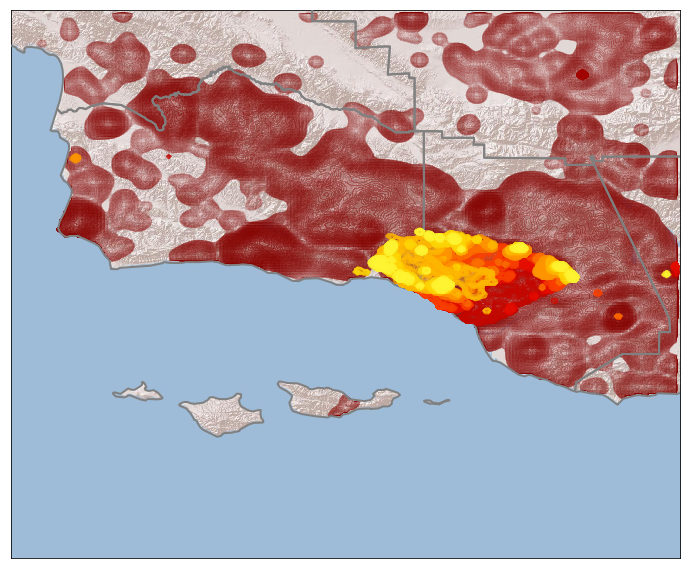

In [21]:
fig, ax = plt.subplots(figsize=(12,12))

m = Basemap(#projection='cyl',
            llcrnrlat=Y.min(), urcrnrlat=Y.max(),
            llcrnrlon=X.min(), urcrnrlon=X.max(), epsg=4269, resolution='h')
#http://server.arcgisonline.com/arcgis/rest/services
#EPSG Number of America is 4269

def landq(pt):
    p = m(*(pt[::-1])) # reverse coordinates and use map projection
    return m.is_land(*p)

land_mask = np.asarray([ landq(pt) for pt in xy * 180 / np.pi ])
land_mask = land_mask.reshape(Z.shape)

m.arcgisimage(service='World_Shaded_Relief', xpixels=1500, verbose=True, ax=ax);

#m.drawmapboundary(fill_color='#DDEEFF');
#m.fillcontinents(color='#FFEEDD');

con = adata
con[~land_mask] = -9999.0
ax.contourf(X, Y, con, levels=alevels, cmap=archive_colormap, zorder=2);

#m.drawcoastlines(color='gray', zorder=3, linewidth=2);
m.drawcounties(color='gray', zorder=3, linewidth=2);

for i, Z in enumerate(v_data):
    con = Z
    con[~land_mask] = -9999.0
    ax.contourf(X, Y, con, levels=levels[2:], cmap=colormaps[i], zorder=4);

In [22]:
fig.savefig('thomas-fire2.png', dpi=200, bbox_inches='tight')

http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-120.801735234,33.4959342375,-118.598264766,35.2992850043&bboxSR=4269&imageSR=4269&size=1500,1227&dpi=96&format=png32&f=image


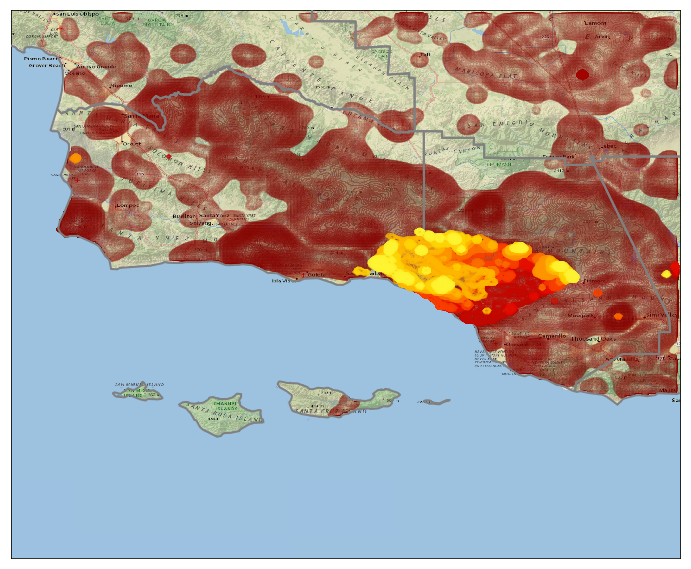

In [29]:
fig, ax = plt.subplots(figsize=(12,12))

m = Basemap(#projection='cyl',
            llcrnrlat=Y.min(), urcrnrlat=Y.max(),
            llcrnrlon=X.min(), urcrnrlon=X.max(), epsg=4269, resolution='h')
#http://server.arcgisonline.com/arcgis/rest/services
#EPSG Number of America is 4269

def landq(pt):
    p = m(*(pt[::-1])) # reverse coordinates and use map projection
    return m.is_land(*p)

land_mask = np.asarray([ landq(pt) for pt in xy * 180 / np.pi ])
land_mask = land_mask.reshape(Z.shape)

m.arcgisimage(service='NatGeo_World_Map', xpixels=1500, verbose=True, ax=ax);

#m.drawmapboundary(fill_color='#DDEEFF');
#m.fillcontinents(color='#FFEEDD');

con = adata
con[~land_mask] = -9999.0
ax.contourf(X, Y, con, levels=alevels, cmap=archive_colormap, zorder=2);

#m.drawcoastlines(color='gray', zorder=3, linewidth=2);
m.drawcounties(color='gray', zorder=3, linewidth=2);

for i, Z in enumerate(v_data):
    con = Z
    con[~land_mask] = -9999.0
    ax.contourf(X, Y, con, levels=levels[2:], cmap=colormaps[i], zorder=4);

In [30]:
fig.savefig('thomas-fire_natgeo.png', dpi=200, bbox_inches='tight')